# Quantization
Quantization is the process of reducing model size so that it can run on EDGE devices.

Deep learning has a growing history of successes, but heavy algorithms running on large graphical processing units are far from ideal. A relatively new family of deep learning methods called quantized neural networks have appeared in answer to this discrepancy. In Leapmind R&D, we are working on quantization methods, among others, for enabling efficient high-performance deep learning computation on small devices.

Neural networks are composed of multiple layers of parameters, each layer transforms the input image, separating and contracting [0] the feature space, resulting in the separation of input images to their various classes. Perhaps the most notable of deep learning problems are image classification, object detection, and segmentation. Here we focus on image classification, as a basis for the other tasks. For image tasks, convolutional layers are highly valuable, which apply linear transformations to each spatial input patch of the image. Convolutional layers have implicit translational invariance, allowing for a reduction in the number of parameters compared to fully-connected layers.




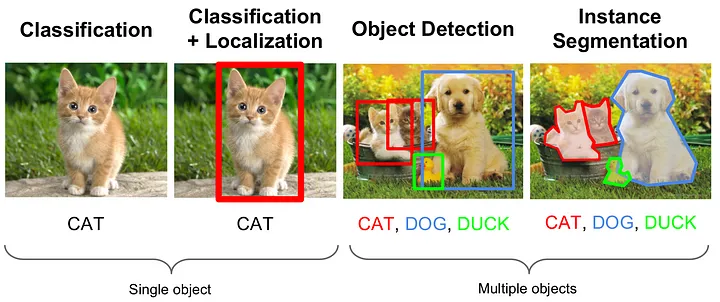

Deep learning for classification tasks involves training the parameters of a neural network such that the algorithm learns to discern between object classes. This is achieved by feeding many images of labelled data to the neural network, while updating the parameters to increase performance on a smooth objective function. A drawback is that a large number of parameters are used, compared to more traditional algorithms.

## Quantized activations

We don’t need to stop with just the parameters of the quantized network - quantizing the inputs to each convolutional layer of the neural network results in massive reduction of necessary computation. Furthermore, the convolution can be carried out in a bitwise manner, which is much more efficient, provided the relevant hardware acceleration is used.

To be able to use quantized inputs for each convolution layer, the activation function is replaced by a quantization function, converting the activations (the network’s internal representation of the input data) to low bit width immediately prior to each convolution. A prime example is the binary network (called BNN) described by M. Courbariaux et al. [5], who build on their work in [2], quantizing the activations to binary values -1 and +1 by taking the sign of the full-precision activations. For this binarizing activation, they use gradient-cancelling for activations that were outside the range [-1,1] (to complement their parameter clipping). Another innovation is an approximate shift based batch normalization that uses addition of floating point numbers rather than multiplications, which reduces the necessary computation.



## Multiple bit width activations
Reducing the bit width of the activations all the way down to binary can harm the accuracy of the neural network. The authors of DoReFa-Net [8] use an activation quantizer that maps to multiple bits. This can allow higher performance while still achieving great savings in computation. Moreover, they describe a quantization procedure for the gradients with the aim of reducing the amount of computation required for training. However, they find that the gradients require stochastic quantization to be able to get good performance.

Today i will:

(1) Train a hand written digits model

(2) Export to a disk and check the size of that model

(3) Use two techniques for quantization (1) post training quantization (3) quantization aware training

In [1]:
# Libraries 
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

2024-06-25 21:26:37.446545: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-25 21:26:37.742252: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-25 21:26:38.981544: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-25 21:26:40.958399: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [4]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [5]:
len(x_train)

60000

In [6]:
len(y_test)

10000

In [7]:
x_train[0].shape

(28, 28)

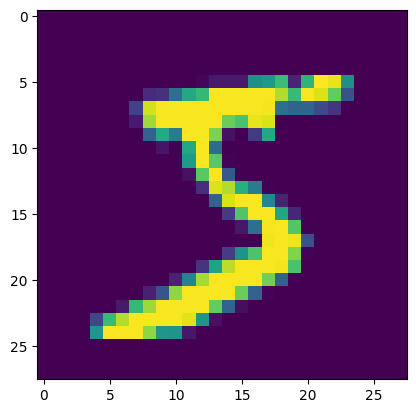

In [8]:
plt.imshow(x_train[0])

In [9]:
y_train[0]

5

In [11]:
# Scaling

x_train = x_train / 255
x_test = x_test / 255


In [12]:
# Reducing the shape of the training and testing

x_train_flatten = x_train.reshape(len(x_train), 28*28)
x_test_flatten = x_test.reshape(len(x_test), 28*28)


In [14]:
x_train_flatten.shape


(60000, 784)

Using Flatten layer so that we don't have to call .reshape on input dataset


In [15]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dense(10, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(x_train, y_train, epochs=5)

/home/jagannath/100OfCode/env/lib/python3.12/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5


2024-06-25 21:35:13.823221: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 188160000 exceeds 10% of free system memory.


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8738 - loss: 0.4444
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9640 - loss: 0.1242
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9749 - loss: 0.0839
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9815 - loss: 0.0623
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9849 - loss: 0.0518


We trained our model, now let's see the performance

In [16]:
model.evaluate(x_test, y_test)

 48/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9836 - loss: 0.0594   

2024-06-25 21:36:23.474789: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 31360000 exceeds 10% of free system memory.


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9737 - loss: 0.0906


[0.07961467653512955, 0.9768999814987183]

x_test: It is our predicted output

y_test: It is the actual output

There is not much difference between them, so our model is doing well.

In [26]:
import os
save_dir = 'saved_model'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Save the model
model_path = os.path.join(save_dir, 'save_model.h5')
model.save(model_path)